# 6.6.1

# Ridge

In [1]:
import numpy as np
from sklearn import metrics, linear_model
from sklearn.model_selection import KFold, cross_val_score
import pandas as pd
import sklearn.linear_model as lm
from sklearn.feature_selection import RFE, SelectKBest
from sklearn.model_selection import train_test_split
from itertools import combinations
import matplotlib.pyplot as plt
import pylab
from sklearn import metrics
import math
import imp
from sklearn.preprocessing import scale

In [2]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

In [3]:
metricsUtil = imp.load_source('MetricsUtil', 'MetricsUtil.py')

HitterData = pd.read_csv('Dataset\Hitters.csv', na_values='?', usecols=range(0,21), parse_dates=True).dropna()

HitterData.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


In [4]:
#HitterData_df=pd.DataFrame(data=HitterData.data,columns=HitterData.feature_names)
#print(HitterData_df.info())
HitterData.index.name = 'Player'
HitterData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Unnamed: 0    263 non-null object
AtBat         263 non-null int64
Hits          263 non-null int64
HmRun         263 non-null int64
Runs          263 non-null int64
RBI           263 non-null int64
Walks         263 non-null int64
Years         263 non-null int64
CAtBat        263 non-null int64
CHits         263 non-null int64
CHmRun        263 non-null int64
CRuns         263 non-null int64
CRBI          263 non-null int64
CWalks        263 non-null int64
League        263 non-null object
Division      263 non-null object
PutOuts       263 non-null int64
Assists       263 non-null int64
Errors        263 non-null int64
Salary        263 non-null float64
NewLeague     263 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 45.2+ KB


In [5]:
dummies = pd.get_dummies(HitterData[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 6 columns):
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: uint8(6)
memory usage: 3.6 KB
        League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
Player                                                                      
1              0         1           0           1            0            1
2              1         0           0           1            1            0
3              0         1           1           0            0            1
4              0         1           1           0            0            1
5              1         0           0           1            1            0


In [6]:
y = HitterData.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = HitterData.drop(['Unnamed: 0','Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7 KB


In [7]:
X.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


In [8]:
alphas = 10**np.linspace(10,-2,100)
alphas

array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+07, 2.84803587e+07, 2.15443469e+07, 1.62975083e+07,
       1.23284674e+07, 9.32603347e+06, 7.05480231e+06, 5.33669923e+06,
       4.03701726e+06, 3.05385551e+06, 2.31012970e+06, 1.74752840e+06,
       1.32194115e+06, 1.00000000e+06, 7.56463328e+05, 5.72236766e+05,
       4.32876128e+05, 3.27454916e+05, 2.47707636e+05, 1.87381742e+05,
       1.41747416e+05, 1.07226722e+05, 8.11130831e+04, 6.13590727e+04,
       4.64158883e+04, 3.51119173e+04, 2.65608778e+04, 2.00923300e+04,
       1.51991108e+04, 1.14975700e+04, 8.69749003e+03, 6.57933225e+03,
       4.97702356e+03, 3.76493581e+03, 2.84803587e+03, 2.15443469e+03,
      

In [9]:
ridge = Ridge(fit_intercept=True, normalize=True)
coeffs = []
intercepts = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit((X), y)
    coeffs.append(ridge.coef_)
    intercepts.append(ridge.intercept_)

In [10]:
print(len(coeffs))
print(len(coeffs[0]))
print(len(intercepts))
print(intercepts[0])

100
19
100
535.92588171039


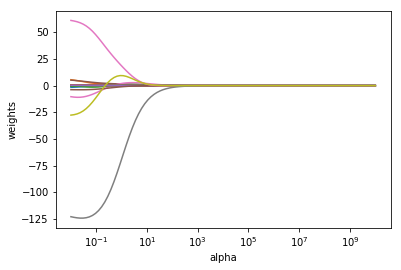

In [11]:
ax = plt.gca()
ax.plot(alphas, coeffs)
ax.set_xscale('log') # try without this line
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

In [12]:
print(alphas[49])
print(math.sqrt(sum(map(lambda x:x*x, coeffs[49]))))
# We may notice the coefficients l2 norm is different from R output 
# I tried a few different normalization methods but still did not get the exact same output 

print(coeffs[49])

11497.569953977356
0.015604015364701386
[ 1.05084190e-04  3.81213219e-04  1.53587268e-03  6.44641457e-04
  6.80918080e-04  8.01446032e-04  3.27704404e-03  9.02214059e-06
  3.32048758e-05  2.50408429e-04  6.66164023e-05  6.87496444e-05
  7.27332307e-05  4.21005722e-05  6.87621309e-06 -3.21056660e-05
 -1.11649125e-03 -1.50775795e-02 -2.19838773e-04]


In [13]:
print(alphas[60])
print(math.sqrt(sum(map(lambda x:x*x, coeffs[60]))))
# We may notice the coefficients l2 norm is different from R output 
# I tried a few different normalization methods but still did not get the exact same output 

print(coeffs[60])

533.6699231206302
0.33432066444400144
[ 2.23556812e-03  8.12126675e-03  3.26281296e-02  1.37250364e-02
  1.44861142e-02  1.70709536e-02  6.95739406e-02  1.91784645e-04
  7.06198740e-04  5.32472798e-03  1.41679646e-03  1.46219121e-03
  1.54546028e-03  9.00399657e-04  1.46911004e-04 -7.05526225e-04
 -2.23450061e-02 -3.23351183e-01 -3.54196343e-03]


In [14]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV

In [15]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.66)

In [16]:
ridge = Ridge(fit_intercept=True, normalize=True, alpha=4)
ridge.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))        # Calculate the test MSE

AtBat           0.075874
Hits            0.337849
HmRun           1.511743
Runs            0.535324
RBI             0.906564
Walks           0.725623
Years           2.080543
CAtBat          0.006539
CHits           0.024144
CHmRun          0.168031
CRuns           0.042945
CRBI            0.054077
CWalks          0.030847
PutOuts         0.061058
Assists        -0.008115
Errors         -1.484767
League_N       12.110114
Division_W    -60.827109
NewLeague_N    16.054424
dtype: float64
122841.60187063924


In [17]:
ridgecv =  RidgeCV(alphas, normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.49770235643321137

In [18]:
ridge_best = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge_best.fit(X_train, y_train)
mean_squared_error(y_test, ridge_best.predict(X_test))

108919.93874471175

In [19]:
pd.Series(ridge_best.coef_, index=X.columns)

AtBat            0.007497
Hits             0.702812
HmRun            0.709488
Runs             0.376829
RBI              2.643607
Walks            0.858438
Years            0.346037
CAtBat           0.011277
CHits            0.048483
CHmRun           0.272187
CRuns            0.063444
CRBI             0.124719
CWalks          -0.061123
PutOuts          0.141661
Assists          0.119872
Errors          -5.639206
League_N        41.010772
Division_W    -192.971970
NewLeague_N     52.654376
dtype: float64

In [20]:
# Af dette kan vi se at ingen af coefficienterne er lig med nul

# 6.6.2

# Lasso

In [21]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import scale 

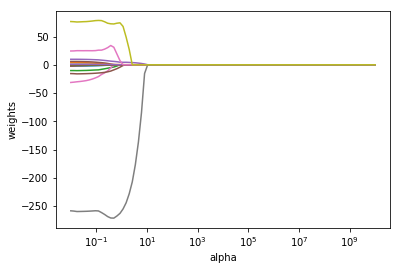

In [22]:
lasso= Lasso(normalize=True, max_iter=10000) 
coeffs = []
alphas = 10**np.linspace(10,-2,100)
for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit((X_train), y_train)
    coeffs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coeffs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

In [23]:
import random
random.seed(1)
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000, normalize=True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

121235.03026343054

In [24]:
print(lassocv.coef_!=0)

[False  True False False  True False False False  True False False  True
 False  True False  True False  True  True]


In [25]:
# Af dette ser vi derfor at vi har et antal af parameterne er lig med nul og at antallet af variablerne der ikke er lig med nul varierer mellem 3 og 9 (ca.)

In [26]:
# Some of the coefficients should reduce to exact zero
pd.Series(lassocv.coef_, index=X.columns)

AtBat            0.000000
Hits             0.128693
HmRun           -0.000000
Runs             0.000000
RBI              4.441382
Walks            0.000000
Years            0.000000
CAtBat           0.000000
CHits            0.061142
CHmRun           0.000000
CRuns            0.000000
CRBI             0.251799
CWalks          -0.000000
PutOuts          0.112962
Assists          0.000000
Errors          -0.693077
League_N         0.000000
Division_W    -250.894059
NewLeague_N     61.008883
dtype: float64

In [27]:
# Vi ser her at nogle af parameterne er nul.